In [109]:
import sys
sys.path.append('../src') # include the src directory


In [110]:
import pandas as pd
from data_splitter import DataSplitter, TrainTestSplit, StratifiedKFoldSplit
from data_prep import prepare_dataset


In [113]:
file_path = '../data/processed/peptide_tools.csv'
df = pd.read_csv(file_path)
df



,Tool,Title,Abstract,DOI,Journal
0,False,Recent Progress in the Discovery and Design of...,Antimicrobial resistance has become a critical...,10.3390/antibiotics11101451,NaN
1,False,Computer-aided design of proline-rich antimicr...,The chemophysical properties of a peptide isol...,10.1080/07391102.2022.2131626,NaN
2,False,Excretory-secretory products from the brown st...,"Over the past decade, evidence has emerged of ...",10.1186/s13071-022-05443-z,NaN
3,True,AMPDeep: hemolytic activity prediction of anti...,Deep learning's automatic feature extraction h...,10.1186/s12859-022-04952-z,NaN
4,False,In Silico Prediction of Anti-Infective and Cel...,The therapeutic potential of venom-derived pep...,10.3390/ph15091141,NaN
...,...,...,...,...,...
251,False,"Identification, structure and differential exp...",Antimicrobial peptides form one of the first l...,10.1046/j.1432-1033.2003.03758.x,NaN
252,False,A novel murine cathelin-like protein expressed...,A novel cDNA encoding a putative secreted prot...,10.1016/0014-5793(96)00692-8,NaN
253,False,Purification and structural characterization o...,Cathelicidins are a novel family of antimicrob...,10.1111/j.1432-1033.1996.0769w.x,NaN
254,False,Identification and characterization of a prima...,Secondary structure prediction studies on CAP1...,10.1016/0014-5793(94)80395-1,NaN


In [114]:
df['Tool'].value_counts()

Tool
False    198
True      58
Name: count, dtype: int64

In [115]:
target = "Tool"
seed = 1

In [117]:
splitter = DataSplitter(TrainTestSplit(test_size=0.15, random_state=seed))
X_temp, X_test, y_temp, y_test = splitter.split(df, target)


2025-08-24 20:52:03,777 - INFO - Splitting data using the selected strategy.
2025-08-24 20:52:03,778 - INFO - Performing stratified train-test split.
2025-08-24 20:52:03,781 - INFO - Train-test split completed.


In [118]:
X_temp

,Title,Abstract,DOI,Journal
76,The Role of Ribonuclease 1 and Ribonuclease In...,Acute kidney injury (AKI) is one of the most c...,10.3390/jcm9103292,NaN
127,Evidence for antimicrobial and anticancer acti...,Pituitary adenylate cyclase-activating polypep...,10.1016/j.fsi.2018.11.056,NaN
16,"New strategy for the design, production and pr...",The intensive salmon farming is associated wit...,10.1016/j.fsi.2022.04.034,NaN
99,Antimicrobial peptide selection from Lippia sp...,Antimicrobial resistance is considered a healt...,10.1016/j.peptides.2020.170317,NaN
165,Empirical comparison of web-based antimicrobia...,Antimicrobial peptides (AMPs) are innate immun...,10.1093/bioinformatics/btx081,NaN
...,...,...,...,...
80,IAMPE: NMR-Assisted Computational Prediction o...,Antimicrobial peptides (AMPs) are at the focus...,10.1021/acs.jcim.0c00841,NaN
228,More effective antimicrobial mastoparan deriva...,Antimicrobial peptides are drugs used against ...,10.1039/c1mb05297g,NaN
1,Computer-aided design of proline-rich antimicr...,The chemophysical properties of a peptide isol...,10.1080/07391102.2022.2131626,NaN
58,Using an Ensemble to Identify and Classify Mac...,The rapid spread of multi-drug resistant micro...,10.1007/s12539-021-00435-6,NaN


In [119]:
y_temp.value_counts()

Tool
False    168
True      49
Name: count, dtype: int64

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report



class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=True, remove_digits=True, remove_punct=True):
        self.lower = lower
        self.remove_digits = remove_digits
        self.remove_punct = remove_punct

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        s = pd.Series(X).fillna('').astype(str)

        def clean(text):
            if self.lower:
                text = text.lower()

            text = re.sub(r'<[^>]+>', ' ', text)

            text = re.sub(r'http\S+|www\.\S+', ' ', text)

            text = re.sub(r'\S+@\S+', ' ', text)

            if self.remove_digits:
                text = re.sub(r'\d+', ' ', text)

            if self.remove_punct:
                text = re.sub(r'[^\w\s]', ' ', text, flags=re.UNICODE)

            text = re.sub(r'\s+', ' ', text).strip()
            return text

        return s.map(clean).tolist()

X_train_val = X_temp.copy()
y_train_val = y_temp.copy()



In [122]:
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('dtm', CountVectorizer()),
    ('clf', LogisticRegression(class_weight='balanced', random_state=seed, max_iter=1000))
])

parameters = {
    'preprocessor__lower': [True],
    'preprocessor__remove_digits': [True, False],
    'preprocessor__remove_punct': [True, False],
    'dtm__max_features': [2000, 5000],
    'dtm__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring=scoring,   # multiple metrics
    refit='f1',        # still select best model based on F1
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

print("Starting hyperparameter search with multiple metrics...".center(60, "="))
grid_search.fit(X_train_val['Abstract'], y_train_val)




==Starting hyperparameter search with multiple metrics...===
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END clf__C=0.1, dtm__max_features=2000, dtm__ngram_range=(1, 1), preprocessor__lower=True, preprocessor__remove_digits=True, preprocessor__remove_punct=True; total time=   0.1s
[CV] END clf__C=0.1, dtm__max_features=2000, dtm__ngram_range=(1, 1), preprocessor__lower=True, preprocessor__remove_digits=True, preprocessor__remove_punct=True; total time=   0.0s
[CV] END clf__C=0.1, dtm__max_features=2000, dtm__ngram_range=(1, 1), preprocessor__lower=True, preprocessor__remove_digits=True, preprocessor__remove_punct=True; total time=   0.0s
[CV] END clf__C=0.1, dtm__max_features=2000, dtm__ngram_range=(1, 1), preprocessor__lower=True, preprocessor__remove_digits=True, preprocessor__remove_punct=True; total time=   0.0s
[CV] END clf__C=0.1, dtm__max_features=2000, dtm__ngram_range=(1, 1), preprocessor__lower=True, preprocessor__remove_digits=True, preprocessor__remov

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor', TextPreprocessor()),
                                       ('dtm', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=1))]),
             n_jobs=1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'dtm__max_features': [2000, 5000],
                         'dtm__ngram_range': [(1, 1), (1, 2)],
                         'preprocessor__lower': [True],
                         'preprocessor__remove_digits': [True, False],
                         'preprocessor__remove_punct': [True, False]},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')},
             verbose=2)

In [123]:
print("\nHyperparameter search completed".center(60, "="))
print("Best found parameters:")
print(grid_search.best_params_)

print(f"\nBest mean F1-score from CV: {grid_search.best_score_:.4f}")

cv_results = grid_search.cv_results_
for metric in ['mean_test_precision', 'mean_test_recall', 'mean_test_f1']:
    value = cv_results[metric][grid_search.best_index_]
    if metric == 'mean_test_f1':
        std_value = cv_results['std_test_f1'][grid_search.best_index_]
        print(f"{metric}: {value:.4f} ± {std_value:.4f}")
    else:
        print(f"{metric}: {value:.4f}")

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test['Abstract'])

print("\nFINAL EVALUATION ON TEST SET".center(60, "="))
print(classification_report(y_test, y_test_pred))

# Test set metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Hyperparameter search completed==============
Best found parameters:
{'clf__C': 0.1, 'dtm__max_features': 2000, 'dtm__ngram_range': (1, 2), 'preprocessor__lower': True, 'preprocessor__remove_digits': False, 'preprocessor__remove_punct': True}

Best mean F1-score from CV: 0.6051
mean_test_precision: 0.6529
mean_test_recall: 0.5711
mean_test_f1: 0.6051 ± 0.0994
FINAL EVALUATION ON TEST SET================
              precision    recall  f1-score   support

       False       0.82      0.90      0.86        30
        True       0.50      0.33      0.40         9

    accuracy                           0.77        39
   macro avg       0.66      0.62      0.63        39
weighted avg       0.74      0.77      0.75        39

Precision: 0.5000
Recall:    0.3333
F1-score:  0.4000


## TFIDF

In [124]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import spacy

class SciSpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="en_core_sci_sm", disable=["ner"], batch_size=32, n_threads=1):
        self.model_name = model_name
        self.disable = disable
        self.batch_size = batch_size
        self.n_threads = n_threads
        self.nlp = None

    def fit(self, X, y=None):
        if self.nlp is None:
            self.nlp = spacy.load(self.model_name, disable=self.disable)
        return self

    def transform(self, X):
        texts = list(X)  
        lemmas = []
        for doc in self.nlp.pipe(texts, batch_size=self.batch_size, n_process=1):
            lemmas.append(" ".join([token.lemma_ for token in doc if not token.is_space]))
        return lemmas


In [125]:

pipeline = Pipeline([
    ('preproc', TextPreprocessor(lower=True, remove_digits=True, remove_punct=True)),
    ('tfidf', TfidfVectorizer()),   
    ('clf', LogisticRegression(class_weight='balanced', random_state=seed, max_iter=1000))
])

parameters = {
    'tfidf__max_features': [1000, 2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring=scoring,   
    refit='f1',        
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

print("Starting hyperparameter search with multiple metrics...".center(60, "="))
grid_search.fit(X_train_val['Abstract'], y_train_val)


==Starting hyperparameter search with multiple metrics...===
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END clf__C=0.1, tfidf__max_features=1000, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END clf__C=0.1, tfidf__max_features=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('preproc', TextPreprocessor()),
                                       ('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=1))]),
             n_jobs=1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__max_features': [1000, 2000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')},
             verbose=2)

In [127]:
print("\nHyperparameter search completed".center(60, "="))
print("Best found parameters:")
print(grid_search.best_params_)

print(f"\nBest mean F1-score from CV: {grid_search.best_score_:.4f}")

cv_results = grid_search.cv_results_
for metric in ['mean_test_precision', 'mean_test_recall', 'mean_test_f1']:
    value = cv_results[metric][grid_search.best_index_]
    if metric == 'mean_test_f1':
        std_value = cv_results['std_test_f1'][grid_search.best_index_]
        print(f"{metric}: {value:.4f} ± {std_value:.4f}")
    else:
        print(f"{metric}: {value:.4f}")

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test['Abstract'])

print("\nFINAL EVALUATION ON TEST SET".center(60, "="))
print(classification_report(y_test, y_test_pred))

# Test set metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Hyperparameter search completed==============
Best found parameters:
{'clf__C': 1, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}

Best mean F1-score from CV: 0.6857
mean_test_precision: 0.6618
mean_test_recall: 0.7133
mean_test_f1: 0.6857 ± 0.1002
FINAL EVALUATION ON TEST SET================
              precision    recall  f1-score   support

       False       0.88      0.93      0.90        30
        True       0.71      0.56      0.62         9

    accuracy                           0.85        39
   macro avg       0.79      0.74      0.76        39
weighted avg       0.84      0.85      0.84        39

Precision: 0.7143
Recall:    0.5556
F1-score:  0.6250


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best = grid_search.best_estimator_

vect = best.named_steps['tfidf']
clf = best.named_steps['clf']

try:
    feat_names = vect.get_feature_names_out()
except AttributeError:

    inv_vocab = {idx: token for token, idx in vect.vocabulary_.items()}
    feat_names = np.array([inv_vocab[i] for i in range(len(inv_vocab))])


coefs = clf.coef_.ravel()  # shape (n_features,)
df = pd.DataFrame({'feature': feat_names, 'coef': coefs})
top_pos = df.sort_values('coef', ascending=False).head(20).reset_index(drop=True)

if len(clf.classes_) == 2:
    positive_class = clf.classes_[1]
else:
    positive_class = clf.classes_[np.argmax(clf.coef_.sum(axis=1))]

print(f"Positive coefficients indicate greater log-odds for class: {positive_class}\n")
print("Top 20 positive features (feature -> coef):\n")
print(top_pos.to_string(index=False))




Positive coefficients indicate greater log-odds for class: True

Top 20 positive features (feature -> coef):

     feature     coef
    accuracy 1.075807
   available 1.035043
          is 1.032368
    features 0.882375
       based 0.858509
   developed 0.856307
          at 0.819710
          on 0.818788
    proposed 0.796806
         our 0.749162
         amp 0.716514
    existing 0.715388
      server 0.706293
     dataset 0.702334
  predicting 0.686234
      freely 0.671974
      target 0.639168
         web 0.636142
experimental 0.615880
         for 0.610238


## Lematize

In [86]:

pipeline = Pipeline([
    ('preproc', TextPreprocessor(lower=True, remove_digits=True, remove_punct=True)),
    ('lemmatizer', SciSpacyLemmatizer(model_name="en_core_sci_sm")), 
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(class_weight='balanced', random_state=seed, max_iter=1000))
])

parameters = {
    'tfidf__max_features': [1000],
    'tfidf__ngram_range': [(1, 1)],
    'clf__C': [1]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring=scoring,   
    refit='f1',        
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

print("Starting hyperparameter search with multiple metrics...".center(60, "="))
grid_search.fit(X_train_val['AbstractText'], y_train_val)


==Starting hyperparameter search with multiple metrics...===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__C=1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   4.3s
[CV] END clf__C=1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   4.3s
[CV] END clf__C=1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   4.7s
[CV] END clf__C=1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   4.3s
[CV] END clf__C=1, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   4.4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('preproc', TextPreprocessor()),
                                       ('lemmatizer', SciSpacyLemmatizer()),
                                       ('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=1))]),
             n_jobs=1,
             param_grid={'clf__C': [1], 'tfidf__max_features': [1000],
                         'tfidf__ngram_range': [(1, 1)]},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')},
             verbose=2)

In [87]:
print("\nHyperparameter search completed".center(60, "="))
print("Best found parameters:")
print(grid_search.best_params_)

print(f"\nBest mean F1-score from CV: {grid_search.best_score_:.4f}")

cv_results = grid_search.cv_results_
for metric in ['mean_test_precision', 'mean_test_recall', 'mean_test_f1']:
    value = cv_results[metric][grid_search.best_index_]
    if metric == 'mean_test_f1':
        std_value = cv_results['std_test_f1'][grid_search.best_index_]
        print(f"{metric}: {value:.4f} ± {std_value:.4f}")
    else:
        print(f"{metric}: {value:.4f}")

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test['AbstractText'])

print("\nFINAL EVALUATION ON TEST SET".center(60, "="))
print(classification_report(y_test, y_test_pred))

# Test set metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Hyperparameter search completed==============
Best found parameters:
{'clf__C': 1, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}

Best mean F1-score from CV: 0.6639
mean_test_precision: 0.6231
mean_test_recall: 0.7133
mean_test_f1: 0.6639 ± 0.1177
FINAL EVALUATION ON TEST SET================
              precision    recall  f1-score   support

       False       0.85      0.93      0.89        30
        True       0.67      0.44      0.53         9

    accuracy                           0.82        39
   macro avg       0.76      0.69      0.71        39
weighted avg       0.81      0.82      0.81        39

Precision: 0.6667
Recall:    0.4444
F1-score:  0.5333


In [42]:
df

,Tool,ArticleTitle,AbstractText,DOI,nameless,notes,Tool_O,notes_O
0,False,Recent Progress in the Discovery and Design of...,Antimicrobial resistance has become a critical...,10.3390/antibiotics11101451,False,NaN,review,NaN
1,False,Computer-aided design of proline-rich antimicr...,The chemophysical properties of a peptide isol...,10.1080/07391102.2022.2131626,False,NaN,no,NaN
2,False,Excretory-secretory products from the brown st...,"Over the past decade, evidence has emerged of ...",10.1186/s13071-022-05443-z,False,NaN,no,NaN
3,True,AMPDeep: hemolytic activity prediction of anti...,Deep learning's automatic feature extraction h...,10.1186/s12859-022-04952-z,False,NaN,yes,not in webpage (recent)
4,False,In Silico Prediction of Anti-Infective and Cel...,The therapeutic potential of venom-derived pep...,10.3390/ph15091141,False,NaN,no,NaN
...,...,...,...,...,...,...,...,...
251,False,"Identification, structure and differential exp...",Antimicrobial peptides form one of the first l...,10.1046/j.1432-1033.2003.03758.x,False,NaN,no,NaN
252,False,A novel murine cathelin-like protein expressed...,A novel cDNA encoding a putative secreted prot...,10.1016/0014-5793(96)00692-8,False,NaN,no,NaN
253,False,Purification and structural characterization o...,Cathelicidins are a novel family of antimicrob...,10.1111/j.1432-1033.1996.0769w.x,False,NaN,no,NaN
254,False,Identification and characterization of a prima...,Secondary structure prediction studies on CAP1...,10.1016/0014-5793(94)80395-1,False,NaN,no,NaN


In [91]:
df.rename(columns={'AbstractText': 'Abstract', 'ArticleTitle': 'Title'}, inplace=True)
df = df[['Tool', 'Title', 'Abstract', 'DOI']]
df

,Tool,Title,Abstract,DOI
0,False,Recent Progress in the Discovery and Design of...,Antimicrobial resistance has become a critical...,10.3390/antibiotics11101451
1,False,Computer-aided design of proline-rich antimicr...,The chemophysical properties of a peptide isol...,10.1080/07391102.2022.2131626
2,False,Excretory-secretory products from the brown st...,"Over the past decade, evidence has emerged of ...",10.1186/s13071-022-05443-z
3,True,AMPDeep: hemolytic activity prediction of anti...,Deep learning's automatic feature extraction h...,10.1186/s12859-022-04952-z
4,False,In Silico Prediction of Anti-Infective and Cel...,The therapeutic potential of venom-derived pep...,10.3390/ph15091141
...,...,...,...,...
251,False,"Identification, structure and differential exp...",Antimicrobial peptides form one of the first l...,10.1046/j.1432-1033.2003.03758.x
252,False,A novel murine cathelin-like protein expressed...,A novel cDNA encoding a putative secreted prot...,10.1016/0014-5793(96)00692-8
253,False,Purification and structural characterization o...,Cathelicidins are a novel family of antimicrob...,10.1111/j.1432-1033.1996.0769w.x
254,False,Identification and characterization of a prima...,Secondary structure prediction studies on CAP1...,10.1016/0014-5793(94)80395-1


In [92]:
df['Journal'] = None

/var/folders/vy/pk443g756t150hf6lsvft54h0000gn/T/ipykernel_13322/3615600711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Journal'] = None


In [ ]:
# df.to_csv('../data/processed/peptide_tools.csv', index=False)

In [93]:
df

,Tool,Title,Abstract,DOI,Journal
0,False,Recent Progress in the Discovery and Design of...,Antimicrobial resistance has become a critical...,10.3390/antibiotics11101451,None
1,False,Computer-aided design of proline-rich antimicr...,The chemophysical properties of a peptide isol...,10.1080/07391102.2022.2131626,None
2,False,Excretory-secretory products from the brown st...,"Over the past decade, evidence has emerged of ...",10.1186/s13071-022-05443-z,None
3,True,AMPDeep: hemolytic activity prediction of anti...,Deep learning's automatic feature extraction h...,10.1186/s12859-022-04952-z,None
4,False,In Silico Prediction of Anti-Infective and Cel...,The therapeutic potential of venom-derived pep...,10.3390/ph15091141,None
...,...,...,...,...,...
251,False,"Identification, structure and differential exp...",Antimicrobial peptides form one of the first l...,10.1046/j.1432-1033.2003.03758.x,None
252,False,A novel murine cathelin-like protein expressed...,A novel cDNA encoding a putative secreted prot...,10.1016/0014-5793(96)00692-8,None
253,False,Purification and structural characterization o...,Cathelicidins are a novel family of antimicrob...,10.1111/j.1432-1033.1996.0769w.x,None
254,False,Identification and characterization of a prima...,Secondary structure prediction studies on CAP1...,10.1016/0014-5793(94)80395-1,None


In [94]:
df[target] = df[target].map({False: 0, True: 1})


/var/folders/vy/pk443g756t150hf6lsvft54h0000gn/T/ipykernel_13322/123596476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].map({False: 0, True: 1})


In [95]:
df

,Tool,Title,Abstract,DOI,Journal
0,0,Recent Progress in the Discovery and Design of...,Antimicrobial resistance has become a critical...,10.3390/antibiotics11101451,None
1,0,Computer-aided design of proline-rich antimicr...,The chemophysical properties of a peptide isol...,10.1080/07391102.2022.2131626,None
2,0,Excretory-secretory products from the brown st...,"Over the past decade, evidence has emerged of ...",10.1186/s13071-022-05443-z,None
3,1,AMPDeep: hemolytic activity prediction of anti...,Deep learning's automatic feature extraction h...,10.1186/s12859-022-04952-z,None
4,0,In Silico Prediction of Anti-Infective and Cel...,The therapeutic potential of venom-derived pep...,10.3390/ph15091141,None
...,...,...,...,...,...
251,0,"Identification, structure and differential exp...",Antimicrobial peptides form one of the first l...,10.1046/j.1432-1033.2003.03758.x,None
252,0,A novel murine cathelin-like protein expressed...,A novel cDNA encoding a putative secreted prot...,10.1016/0014-5793(96)00692-8,None
253,0,Purification and structural characterization o...,Cathelicidins are a novel family of antimicrob...,10.1111/j.1432-1033.1996.0769w.x,None
254,0,Identification and characterization of a prima...,Secondary structure prediction studies on CAP1...,10.1016/0014-5793(94)80395-1,None


In [ ]:


df['word_count'] = df['Abstract'].str.split().str.len()

avg_words = df['word_count'].mean()

print(f"Średnia liczba słów w Abstract: {avg_words:.2f}")


Średnia liczba słów w Abstract: 207.18


/var/folders/vy/pk443g756t150hf6lsvft54h0000gn/T/ipykernel_13322/4158818331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['Abstract'].str.split().str.len()


In [105]:
df

,Tool,Title,Abstract,DOI,Journal,word_count
0,0,Recent Progress in the Discovery and Design of...,Antimicrobial resistance has become a critical...,10.3390/antibiotics11101451,None,228
1,0,Computer-aided design of proline-rich antimicr...,The chemophysical properties of a peptide isol...,10.1080/07391102.2022.2131626,None,202
2,0,Excretory-secretory products from the brown st...,"Over the past decade, evidence has emerged of ...",10.1186/s13071-022-05443-z,None,248
3,1,AMPDeep: hemolytic activity prediction of anti...,Deep learning's automatic feature extraction h...,10.1186/s12859-022-04952-z,None,286
4,0,In Silico Prediction of Anti-Infective and Cel...,The therapeutic potential of venom-derived pep...,10.3390/ph15091141,None,258
...,...,...,...,...,...,...
251,0,"Identification, structure and differential exp...",Antimicrobial peptides form one of the first l...,10.1046/j.1432-1033.2003.03758.x,None,223
252,0,A novel murine cathelin-like protein expressed...,A novel cDNA encoding a putative secreted prot...,10.1016/0014-5793(96)00692-8,None,91
253,0,Purification and structural characterization o...,Cathelicidins are a novel family of antimicrob...,10.1111/j.1432-1033.1996.0769w.x,None,288
254,0,Identification and characterization of a prima...,Secondary structure prediction studies on CAP1...,10.1016/0014-5793(94)80395-1,None,104


In [106]:
df['word_count'].describe()

count    256.000000
mean     207.179688
std       56.985507
min       62.000000
25%      174.000000
50%      200.000000
75%      240.000000
max      414.000000
Name: word_count, dtype: float64

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [145]:
results = pd.read_csv('../data/processed/peptide-results.csv')
results

,Name,best_val_f1,test_f1,cv,unfreeze_last_k_layers,seq_max_length,learning_rate,weight_decay,best_val_precision,best_val_recall,...,total_flos,train/epoch,train/global_step,train/grad_norm,train/learning_rate,train_loss,train_runtime,train_samples_per_second,train_steps_per_second,best_val_accuracy
0,title_cambridgeltl/SapBERT-from-PubMedBERT-ful...,0.800000,0.714286,4,12,512,0.00003,0.2,0.800000,0.800000,...,228906618163200,5,55,0.784750,0.000004,0.345168,26.8755,32.371,2.046,0.906977
1,title_cambridgeltl/SapBERT-from-PubMedBERT-ful...,0.909091,0.600000,3,12,512,0.00003,0.2,0.833333,1.000000,...,228906618163200,5,55,5.293172,0.000004,0.388809,24.7521,35.149,2.222,0.953488
2,title_cambridgeltl/SapBERT-from-PubMedBERT-ful...,0.800000,0.615385,2,12,512,0.00003,0.2,0.727273,0.888889,...,228906618163200,5,55,1.352679,0.000004,0.366436,22.8725,38.037,2.405,0.906977
3,title_cambridgeltl/SapBERT-from-PubMedBERT-ful...,0.900000,0.615385,1,12,512,0.00003,0.2,0.900000,0.900000,...,227591062886400,5,55,1.151713,0.000004,0.360612,24.8514,34.807,2.213,0.954545
4,title_cambridgeltl/SapBERT-from-PubMedBERT-ful...,0.857143,0.714286,0,12,512,0.00003,0.2,0.818182,0.900000,...,227591062886400,5,55,3.819962,0.000004,0.370084,27.4023,31.567,2.007,0.931818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,title_microsoft/BiomedNLP-BiomedBERT-base-unca...,0.800000,0.714286,4,6,370,0.00003,0.1,0.800000,0.800000,...,165420798282000,5,55,1.844092,0.000004,0.379434,20.9341,41.559,2.627,0.906977
71,title_microsoft/BiomedNLP-BiomedBERT-base-unca...,0.952381,0.615385,3,6,370,0.00003,0.1,0.909091,1.000000,...,165420798282000,5,55,3.521606,0.000004,0.399259,16.7648,51.894,3.281,0.976744
72,title_microsoft/BiomedNLP-BiomedBERT-base-unca...,0.888889,0.615385,2,6,370,0.00003,0.1,0.888889,0.888889,...,165420798282000,5,55,4.337500,0.000004,0.406784,17.1613,50.696,3.205,0.953488
73,title_microsoft/BiomedNLP-BiomedBERT-base-unca...,0.736842,0.714286,1,6,370,0.00003,0.1,0.777778,0.700000,...,164470104039000,5,55,1.428307,0.000004,0.362215,17.0386,50.767,3.228,0.886364


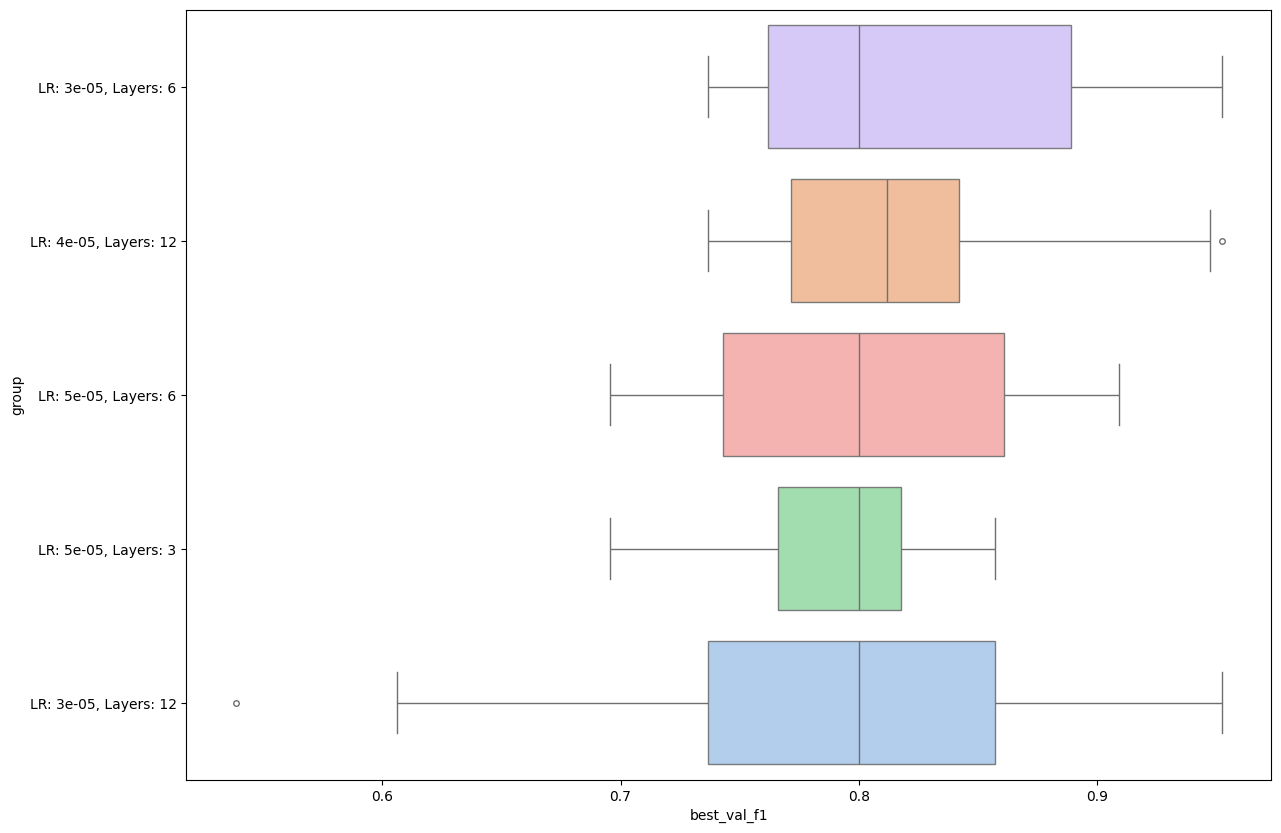

In [146]:

df = results.copy()
df['lr'] = df['learning_rate'].astype(str)
metric = 'best_val_f1'   


df['group'] = df.apply(
    lambda r: f"LR: {r['lr']}, Layers: {int(r['unfreeze_last_k_layers'])}",
    axis=1
)


group_order = (df.groupby('group')[metric]
                 .mean()
                 .sort_values(ascending=False)
                 .index
                 .tolist())


palette = sns.color_palette("pastel", n_colors=len(group_order))


plt.figure(figsize=(14, 10))
ax = sns.boxplot(
    data=df,
    y='group',
    x=metric,
    order=group_order,
    hue = 'group',
    palette=palette,
    fliersize=4,
    linewidth=1.0,
    whis=1.5,         
    boxprops=dict(alpha=0.9)
)

plt.show()


In [147]:

summary = df.groupby(['group'])['best_val_f1'].agg(
    mean='mean',
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75),
    std='std',
    count='count',
    min = "min",
    max='max'
).reset_index()
summary.sort_values(by="mean", ascending=False)

,group,mean,q1,q3,std,count,min,max
1,"LR: 3e-05, Layers: 6",0.828003,0.761905,0.888889,0.090333,5,0.736842,0.952381
2,"LR: 4e-05, Layers: 12",0.825624,0.771429,0.842105,0.074841,10,0.736842,0.952381
4,"LR: 5e-05, Layers: 6",0.798556,0.743108,0.860795,0.076059,10,0.695652,0.909091
3,"LR: 5e-05, Layers: 3",0.790999,0.765873,0.817647,0.050659,10,0.695652,0.857143
0,"LR: 3e-05, Layers: 12",0.785326,0.736842,0.857143,0.101744,40,0.538462,0.952381


In [5]:
#!/usr/bin/env python3
"""
Analyze a CSV file with experiment results (amyloid_results.csv).
The script groups data by: _name_or_path, learning_rate, unfreeze_last_k_layers
and computes means (and stds and counts) for the metrics:
 - best_train_f1
 - best_val_f1
 - best_val_precision
 - best_val_recall
 - test_f1

Additionally: standard deviations (std) for best_val_f1 and test_f1 are included.

The summary is written to the path defined by OUTPUT_PATH (default: amyloid_summary_by_model.csv).

Note: run in an environment with pandas installed (e.g. conda/pip install pandas).
"""


INPUT_PATH = "../data/processed/peptide-results.csv"
OUTPUT_PATH = "amyloid_summary_by_model.csv"

GROUP_COLS = [
    '_name_or_path',
    'learning_rate',
    'unfreeze_last_k_layers',
    "title_abstract_journal",
    "seq_max_length",
    'weight_decay'
]
METRICS = [
    'best_train_f1',
    'best_val_f1',
    'best_val_precision',
    'best_val_recall',
    'test_f1'
]


def load_data(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File does not exist: {path}")
    df = pd.read_csv(path)
    if 'title_abstract_journal' in df.columns:
        df['title_abstract_journal'] = df['title_abstract_journal'].fillna(False)
    return df


def validate_columns(df: pd.DataFrame):
    missing = [c for c in GROUP_COLS + METRICS if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in CSV: {missing}")


def summarize(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(GROUP_COLS)[METRICS].agg(['mean', 'std', 'count'])
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

    count_cols = [c for c in grouped.columns if c.endswith('_count')]
    if not count_cols:
        print("Warning: no _count columns found after aggregation")
    else:
        sample_count_col = count_cols[0]
        counts = grouped[sample_count_col]
        if not (counts == 5).all():
            print("Warning: not all groups have 5 CV records. Count distribution:")
            print(counts.value_counts())

    mean_cols = [c for c in grouped.columns if c.endswith('_mean')]

    std_metrics_to_include = ['best_val_f1', 'test_f1']
    std_cols = [f"{m}_std" for m in std_metrics_to_include if f"{m}_std" in grouped.columns]

    selected_cols = mean_cols + std_cols
    summary = grouped[selected_cols].copy()

    new_columns = []
    for c in summary.columns:
        if c.endswith('_mean'):
            new_columns.append(c.replace('_mean', ''))
        else:
            new_columns.append(c)
    summary.columns = new_columns

    summary = summary.reset_index()

    round_map = {m: 4 for m in METRICS if m in summary.columns}
    for m in std_metrics_to_include:
        std_col = f"{m}_std"
        if std_col in summary.columns:
            round_map[std_col] = 4

    summary = summary.round(round_map)

    return summary


def main():
    df = load_data(INPUT_PATH)
    print(f"Loaded file: {INPUT_PATH} (rows: {len(df)})")

    unique_groups = df.groupby(GROUP_COLS).ngroups
    print(f"Number of unique groups (by {GROUP_COLS}): {unique_groups}")

    try:
        validate_columns(df)
    except KeyError as e:
        print(str(e))
        return

    summary = summarize(df)


    if 'best_val_f1' in summary.columns:
        summary = summary.sort_values(by='best_val_f1', ascending=False)

    print('\nTop 10 results (means):')
    print(summary.head(10).to_string(index=False))

    return summary


if __name__ == "__main__":
    main()


Loaded file: ../data/processed/peptide-results.csv (rows: 75)
Number of unique groups (by ['_name_or_path', 'learning_rate', 'unfreeze_last_k_layers', 'title_abstract_journal', 'seq_max_length', 'weight_decay']): 15

Top 10 results (means):
                                       _name_or_path  learning_rate  unfreeze_last_k_layers  title_abstract_journal  seq_max_length  weight_decay  best_train_f1  best_val_f1  best_val_precision  best_val_recall  test_f1  best_val_f1_std  test_f1_std
       cambridgeltl/SapBERT-from-PubMedBERT-fulltext        0.00003                      12                    True             512          0.10         0.8890       0.8609              0.8491           0.8778   0.6319           0.0641       0.0888
       cambridgeltl/SapBERT-from-PubMedBERT-fulltext        0.00003                      12                    True             512          0.20         0.8496       0.8532              0.8158           0.8978   0.6519           0.0524       0.0573
microsoft

In [6]:
res = main()

Loaded file: ../data/processed/peptide-results.csv (rows: 75)
Number of unique groups (by ['_name_or_path', 'learning_rate', 'unfreeze_last_k_layers', 'title_abstract_journal', 'seq_max_length', 'weight_decay']): 15

Top 10 results (means):
                                       _name_or_path  learning_rate  unfreeze_last_k_layers  title_abstract_journal  seq_max_length  weight_decay  best_train_f1  best_val_f1  best_val_precision  best_val_recall  test_f1  best_val_f1_std  test_f1_std
       cambridgeltl/SapBERT-from-PubMedBERT-fulltext        0.00003                      12                    True             512          0.10         0.8890       0.8609              0.8491           0.8778   0.6319           0.0641       0.0888
       cambridgeltl/SapBERT-from-PubMedBERT-fulltext        0.00003                      12                    True             512          0.20         0.8496       0.8532              0.8158           0.8978   0.6519           0.0524       0.0573
microsoft

In [7]:
res

,_name_or_path,learning_rate,unfreeze_last_k_layers,title_abstract_journal,seq_max_length,weight_decay,best_train_f1,best_val_f1,best_val_precision,best_val_recall,test_f1,best_val_f1_std,test_f1_std
6,cambridgeltl/SapBERT-from-PubMedBERT-fulltext,0.00003,12,True,512,0.10,0.8890,0.8609,0.8491,0.8778,0.6319,0.0641,0.0888
7,cambridgeltl/SapBERT-from-PubMedBERT-fulltext,0.00003,12,True,512,0.20,0.8496,0.8532,0.8158,0.8978,0.6519,0.0524,0.0573
12,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00004,12,True,512,0.20,0.8743,0.8523,0.8273,0.8800,0.6154,0.0904,0.0000
11,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00003,12,True,512,0.10,0.8655,0.8406,0.8251,0.8578,0.5923,0.0780,0.0516
10,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00003,12,True,370,0.10,0.8723,0.8302,0.8065,0.8600,0.6264,0.0923,0.0527
8,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00003,6,True,370,0.10,0.8253,0.8280,0.8206,0.8378,0.6319,0.0903,0.0888
14,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00005,6,True,350,0.05,0.8788,0.8193,0.8055,0.8378,0.6256,0.0764,0.0229
2,allenai/biomed_roberta_base,0.00004,12,True,512,0.20,0.8411,0.7989,0.8147,0.7956,0.6129,0.0514,0.2342
13,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00005,3,True,350,0.05,0.8412,0.7959,0.7996,0.7956,0.6549,0.0479,0.0542
3,bert-base-uncased,0.00005,3,True,350,0.05,0.8744,0.7861,0.8217,0.7733,0.5374,0.0585,0.0535


In [8]:
res.sort_values(by='test_f1', ascending=False)

,_name_or_path,learning_rate,unfreeze_last_k_layers,title_abstract_journal,seq_max_length,weight_decay,best_train_f1,best_val_f1,best_val_precision,best_val_recall,test_f1,best_val_f1_std,test_f1_std
1,allenai/biomed_roberta_base,0.00003,12,True,512,0.10,0.8096,0.7544,0.7465,0.7956,0.6973,0.0501,0.0788
13,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00005,3,True,350,0.05,0.8412,0.7959,0.7996,0.7956,0.6549,0.0479,0.0542
7,cambridgeltl/SapBERT-from-PubMedBERT-fulltext,0.00003,12,True,512,0.20,0.8496,0.8532,0.8158,0.8978,0.6519,0.0524,0.0573
4,bert-base-uncased,0.00005,6,True,350,0.05,0.9083,0.7778,0.7731,0.7956,0.6481,0.0781,0.0637
6,cambridgeltl/SapBERT-from-PubMedBERT-fulltext,0.00003,12,True,512,0.10,0.8890,0.8609,0.8491,0.8778,0.6319,0.0641,0.0888
8,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00003,6,True,370,0.10,0.8253,0.8280,0.8206,0.8378,0.6319,0.0903,0.0888
10,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00003,12,True,370,0.10,0.8723,0.8302,0.8065,0.8600,0.6264,0.0923,0.0527
14,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00005,6,True,350,0.05,0.8788,0.8193,0.8055,0.8378,0.6256,0.0764,0.0229
12,microsoft/BiomedNLP-BiomedBERT-base-uncased-ab...,0.00004,12,True,512,0.20,0.8743,0.8523,0.8273,0.8800,0.6154,0.0904,0.0000
2,allenai/biomed_roberta_base,0.00004,12,True,512,0.20,0.8411,0.7989,0.8147,0.7956,0.6129,0.0514,0.2342
